"""
NHS South-West: hub-and-spoke link diagram + dendrogram
-------------------------------------------------------
Assumes the three enriched CSVs live in the same directory as this script:
    • NHS_SW_Acute_Hospitals_enriched.csv
    • NHS_SW_Community_Diagnostic_Centres_enriched.csv
    • NHS_SW_Community_Hospitals_enriched.csv
"""

In [1]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from pathlib import Path


In [7]:
# 1.  Load and tidy

DATA_DIR = Path(
    "/Users/rosstaylor/Downloads/Research Project/Code Folder/"
    "Research Project - Geospatial Health Demand/"
    "data/processed/Health Infrastructure/enriched/"
)

# ---------------------------------------------------------------------------
# Load
# ---------------------------------------------------------------------------
acute_path = DATA_DIR / "NHS_SW_Acute_Hospitals_enriched.csv"
cdc_path   = DATA_DIR / "NHS_SW_ Community_Diagnostic_Centres_enriched.csv"
ch_path    = DATA_DIR / "NHS_SW_Community_Hospitals_enriched.csv"

acute = pd.read_csv(acute_path)
cdc   = pd.read_csv(cdc_path)
ch    = pd.read_csv(ch_path)

# ---------------------------------------------------------------------------
# Tidy
# ---------------------------------------------------------------------------
cols = {"Name": "name", "latitude": "lat", "longitude": "lon"}

acute = acute[list(cols)].rename(columns=cols).assign(type="Acute")
cdc   = cdc[list(cols)].rename(columns=cols).assign(type="CDC")
ch    = ch[list(cols)].rename(columns=cols).assign(type="Community hospital")


In [8]:
# 2.  Great-circle distance

R_EARTH = 6_371.0  # km

def haversine(lat1, lon1, lat2, lon2):
    """Great-circle distance between two lat/lon points."""
    ϕ1, λ1, ϕ2, λ2 = map(radians, (lat1, lon1, lat2, lon2))
    dϕ, dλ = ϕ2 - ϕ1, λ2 - λ1
    a = sin(dϕ/2)**2 + cos(ϕ1) * cos(ϕ2) * sin(dλ/2)**2
    return 2 * R_EARTH * atan2(sqrt(a), sqrt(1 - a))


# 3.  Attach each spoke to its nearest acute


def attach_nearest_acute(df, acute_df):
    """Add columns: nearest_acute, dist_km."""
    nearest, dist_km = [], []
    for _, row in df.iterrows():
        dists = acute_df.apply(
            lambda a: haversine(row.lat, row.lon, a.lat, a.lon), axis=1
        )
        idx = dists.idxmin()
        nearest.append(acute_df.loc[idx, "name"])
        dist_km.append(dists.loc[idx])
    out = df.copy()
    out["nearest_acute"] = nearest
    out["dist_km"] = dist_km
    return out

cdc = attach_nearest_acute(cdc, acute)
ch  = attach_nearest_acute(ch,  acute)

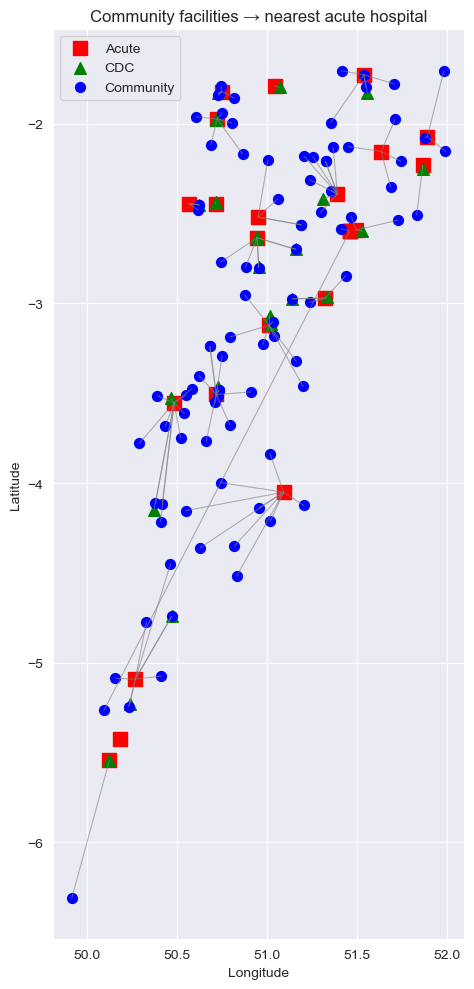

In [9]:
# 4.  Plot the link diagram (optional)

def plot_links(acute, cdc, ch):
    plt.figure(figsize=(8, 10))
    plt.scatter(acute.lon, acute.lat,  s=90, marker="s", color="red",   label="Acute")
    plt.scatter(cdc.lon,   cdc.lat,    s=70, marker="^", color="green", label="CDC")
    plt.scatter(ch.lon,    ch.lat,     s=50, marker="o", color="blue",  label="Community")

    # spokes
    spokes = pd.concat([cdc, ch])
    for _, spoke in spokes.iterrows():
        hub = acute.loc[acute.name == spoke.nearest_acute].iloc[0]
        plt.plot([spoke.lon, hub.lon], [spoke.lat, hub.lat],
                 lw=0.8, color="grey", alpha=0.6)

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Community facilities → nearest acute hospital")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_links(acute, cdc, ch)         # ⬅ uncomment if you want the map



In [10]:
# 5.  Build a *constrained* distance matrix for the dendrogram


# Combine everything into one DataFrame
fac = pd.concat([acute, cdc, ch], ignore_index=True)
fac.reset_index(drop=True, inplace=True)

# Each row’s hub ID  = itself (if acute)  OR  its nearest_acute
fac["hub_id"] = np.where(fac.type == "Acute", fac.name, fac.nearest_acute)

# Pairwise distance matrix — custom rule:
#   • same hub  → real haversine distance
#   • different hub → VERY large constant (far) so hubs only meet at the root
FAR = 500.0   # km  – anything larger than the maximum intra-hub distance

n = len(fac)
d_condensed = []        # SciPy’s 1-D “condensed” distance vector
for i in range(n - 1):
    for j in range(i + 1, n):
        if fac.hub_id[i] == fac.hub_id[j]:
            d = haversine(fac.lat[i], fac.lon[i], fac.lat[j], fac.lon[j])
        else:
            d = FAR
        d_condensed.append(d)

d_condensed = np.asarray(d_condensed)

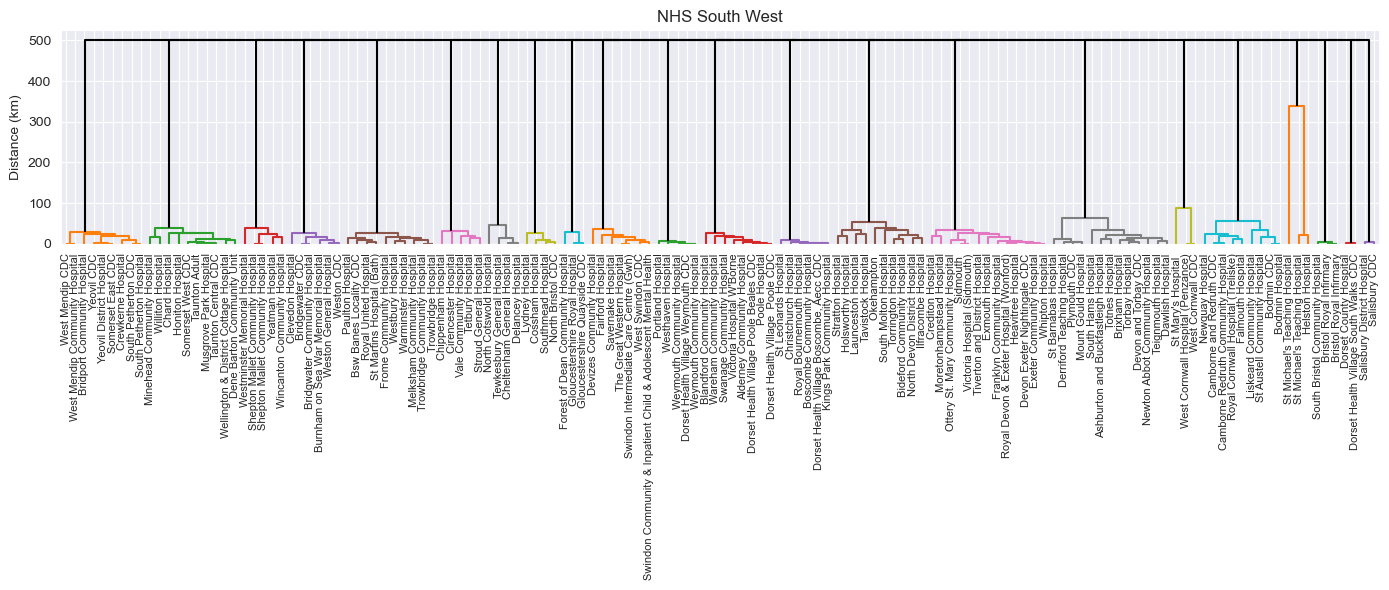

In [11]:
# 6.  Hierarchical clustering & dendrogram


# Linkage – average works nicely for geography
Z = linkage(d_condensed, method="average")

plt.figure(figsize=(14, 6))
dendrogram(
    Z,
    labels=fac.name.values,
    leaf_rotation=90,
    above_threshold_color="black",
    color_threshold=FAR * 0.999   # ensures all hubs share the same colour
)

# Cosmetic--—
plt.title("NHS South West")
plt.ylabel("Distance (km)")
plt.xticks(fontsize=8)
plt.tight_layout()
plt.show()